# Démonstration de l'efficacité de la méthode stochastique 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, ShuffleSplit, validation_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
np.random.seed(306)

On utilise la fonction ShuffleSplit comme stratégie de cross validation.

In [3]:
shuffle_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

On charge les données et on les sépare pour le training et le test.

In [4]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)
com_train_features, test_features, com_train_labels, test_labels = train_test_split(features, labels, random_state=42)

On divise les données dans les train et dev sets

In [5]:
train_features, dev_features, train_labels, dev_labels = train_test_split(com_train_features, com_train_labels, random_state=42)

Pour résumer, une stratégie de cross-validation est définie à l'aide de ShuffleSplit, et les données sont divisées en ensembles d'entraînement, de développement et de test.

## SGD Regressor

#### Etape 1 : Pour commencer, nous instancions un modèle SGDRegressor comme baseline avec des paramètres par défaut.
#### Etape 2 : On entraîne le modèle avec les matrices et les instances des training features.
#### Etape 3 : On obtient le score sur les données du training et developp

In [6]:
sgd = SGDRegressor(random_state=42)
sgd.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd.predict(dev_features))
print ("Erreur moyenne absolue sur le Training set : ", train_mae)
print ("Erreur moyenne absolue sur le Dev set : ", dev_mae)

Erreur moyenne absolue sur le Training set :  312747257037604.56
Erreur moyenne absolue sur le Dev set :  315884696981612.4


Les performances du modèle de base sont évaluées en termes d'erreur moyenne absolue sur les ensembles d'entraînement et de développement.

On observe que la MAE est trop forte. Le modèle de base ne s'entraîne pas correctement. On va donc entrainer le modèle étape par étape et en enregistrant les pertes du training à chaque étape.

# Ajouter une étape de feature scaling

In [7]:
sgd_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                         ("sgd", SGDRegressor())])
sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))

print ("MAE sur le Training set : ", train_mae)
print ("MAE sur le Dev set : ", dev_mae)

MAE sur le Training set :  0.7120658904697411
MAE sur le Dev set :  0.980422924207352


Un pipeline est créé avec une étape de mise à l'échelle des caractéristiques avant le modèle SGDRegressor, puis le pipeline est entraîné sur les données d'entraînement.

On remarque une erreur toujours élevée sur le training set

In [ ]:
eta0 = 1e-2
sgd_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                         ("SGD", SGDRegressor(max_iter=1, tol=1e-3,
                                              warm_start=True,
                                              random_state=42))])

loss = []
for epoch in range(100):
    sgd_pipeline.fit(train_features, train_labels)
    loss.append(mean_squared_error(train_labels, sgd_pipeline.predict(train_features)))

plt.plot(np.arange(len(loss)), loss, 'b-')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title(f'Learning curve: eta0={eta0:.4f}')

Le modèle SGDRegressor est entraîné étape par étape, et les pertes sur l'ensemble d'entraînement sont enregistrées pour visualisation.

La perte réduit au départ puis augmente, ce qui peut s'expliquer par des taux d'apprentissage trop larges. Nous allons réduire le learning rate par un facteur 10.

In [ ]:
eta0 = 1e-3
sgd_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                         ("SGD", SGDRegressor(max_iter=1, tol=1e-3,
                                              warm_start=True, eta0=eta0,
                                              random_state=42))])

loss = []
for epoch in range(100):
    sgd_pipeline.fit(train_features, train_labels)
    loss.append(mean_squared_error(train_labels, sgd_pipeline.predict(train_features)))

plt.plot(np.arange(len(loss)), loss, 'b-')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title(f'Learning curve: eta0={eta0:.4f}')

Le taux d'apprentissage est réduit par un facteur de 10 pour observer son impact sur la courbe d'apprentissage.

In [10]:
print ("Iterations avant d'atteindre le critère de convergence : ", sgd_pipeline[-1].n_iter_)
print ("Weight updates : ", sgd_pipeline[-1].t_)

Iterations avant d'atteindre le critère de convergence :  1
Weight updates :  11611.0


In [11]:
train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print ("MAE sur le training set : ", train_mae)
print ("MAE sur le Dev set : ", dev_mae)

MAE sur le training set :  0.5333732983042573
MAE sur le Dev set :  0.5190150280908042


# Fixer le learning rate grâce à des courbes de validation

In [ ]:
%%time
eta0 = [1e-5, 1e-4, 1e-3, 1e-2]
train_score, test_score = validation_curve(
    sgd_pipeline, com_train_features, com_train_labels, param_name='SGD__eta0',
    param_range=eta0, cv=shuffle_split_cv, scoring="neg_mean_squared_error",
    n_jobs=2)
train_errors, test_errors = -train_score, -test_score

Une courbe de validation est tracée pour sélectionner le meilleur taux d'apprentissage.

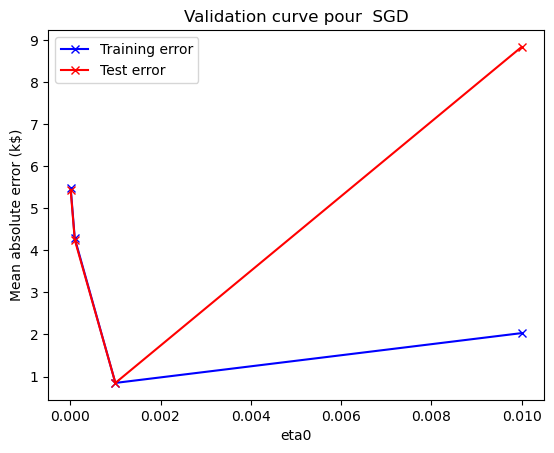

In [13]:
train_errors, test_errors = -train_score, -test_score
plt.plot(eta0, train_errors.mean(axis=1), 'b-x', label="Training error")
plt.plot(eta0, test_errors.mean(axis=1), 'r-x', label="Test error")
plt.legend()

plt.xlabel("eta0")
plt.ylabel("Mean absolute error (k$)")
_ = plt.title("Validation curve pour  SGD")

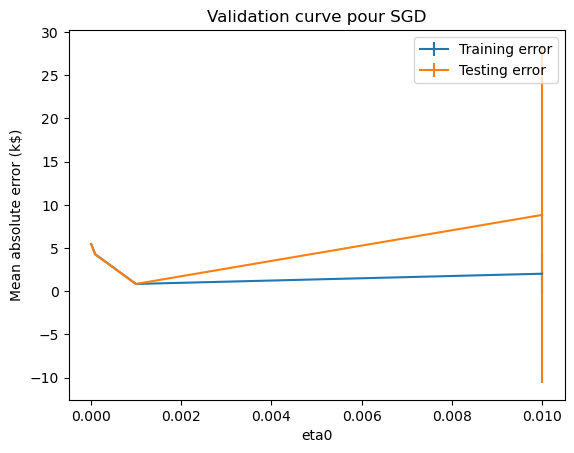

In [14]:
plt.errorbar(eta0, train_errors.mean(axis=1),
             yerr=train_errors.std(axis=1), label='Training error')
plt.errorbar(eta0, test_errors.mean(axis=1),
             yerr=test_errors.std(axis=1), label='Testing error')
plt.legend()

plt.xlabel("eta0")
plt.ylabel("Mean absolute error (k$)")
_ = plt.title("Validation curve pour SGD")

In [15]:
sgd_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                         ("sgd", SGDRegressor(max_iter=500,
                                              early_stopping=True,
                                              eta0=1e-3,
                                              tol=1e-3,
                                              validation_fraction=0.2,
                                              n_iter_no_change=5,
                                              average=10,
                                              random_state=42))])
sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))

print("MAE sur le Training set : ", train_mae)
print("MAE sur le Dev set : ", dev_mae)

MAE sur le Training set :  0.5433287489797833
MAE sur le Dev set :  0.5345612073911921


In [16]:
print("Nombre d'itérations du SGD : ", sgd_pipeline[-1].n_iter_)
print("Nombre de weight updates : ", sgd_pipeline[-1].t_)

Nombre d'itérations du SGD :  35
Nombre de weight updates :  406351.0


In [17]:
sgd_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                         ("sgd", SGDRegressor(max_iter=500,
                                              early_stopping=True,
                                              eta0=1e-3,
                                              tol=1e-3,
                                              learning_rate="constant",
                                              validation_fraction=0.2,
                                              n_iter_no_change=5,
                                              average=10,
                                              random_state=42))])
sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))

print("MAE sur le Training set : ", train_mae)
print("MAE sur le Dev set : ", dev_mae)

print("Nombre d'itérations du SGD : ", sgd_pipeline[-1].n_iter_)
print("Nombre de weight updates : ", sgd_pipeline[-1].t_)

MAE sur le Training set :  0.5528203432984674
MAE sur le Dev set :  0.5689568216133665
Nombre d'itérations du SGD :  11
Nombre de weight updates :  127711.0


Le modèle final est entraîné avec le meilleur taux d'apprentissage sélectionné.

In [18]:
sgd_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                         ("sgd", SGDRegressor(max_iter=500,
                                              early_stopping=True,
                                              eta0=1e-3,
                                              tol=1e-3,
                                              learning_rate="adaptive",
                                              validation_fraction=0.2,
                                              n_iter_no_change=5,
                                              average=10,
                                              random_state=42))])
sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))

print("MAE sur le Training set : ", train_mae)
print("MAE sur le Dev set : ", dev_mae)

print("Nombre d'itérations du SGD : ", sgd_pipeline[-1].n_iter_)
print("Nombre de weight updates : ", sgd_pipeline[-1].t_)

MAE sur le Training set :  0.5375525445454805
MAE sur le Dev set :  0.520025474075991
Nombre d'itérations du SGD :  40
Nombre de weight updates :  464401.0


Les performances du modèle final sont évaluées sur les ensembles d'entraînement et de développement.